In [1]:
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from autoencoder import combined_loss
import tensorflow as tf
from skopt import gp_minimize
from tensorflow.keras.callbacks import EarlyStopping
from autoencoder import objective_function_tf
from sklearn.gaussian_process.kernels import Matern

from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

from autoencoder import create_train_val_set, create_autoencoder, create_autoencoder_enhanced, fit_autoencoder, fit_denoising_autoencoder, plot_history, fit_vae, create_vae, fit_autoencoder_custom
from latent_bo import objective_function

### Helpers

In [2]:
def optimize_designs(encoder, decoder, encoder_noisy, decoder_noisy, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=10, n_iterations=3, use_denoising=True, use_normal=True):
    results = []
    all_designs = []

    for rep in tqdm(range(n_repetitions)):
        cordex_mat, cordex_opt = cordex_discrete(runs=runs,
                                                 f_list=n_x,
                                                 scalars=scalars,
                                                 levels=[-1, 1],
                                                 epochs=5,
                                                 optimality=optimality,
                                                 J_cb=J_cb,
                                                 disable_bar=True)

        objective_function_values = [cordex_opt]
        designs = [cordex_mat]


        if use_denoising:
            for i in range(n_iterations):
                encoded_denoise = encoder_noisy.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_denoise = decoder_noisy.predict(encoded_denoise, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_denoise), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_denoise)
                cordex_mat = decoded_denoise
        if use_normal:
            for j in range(n_iterations):
                encoded_result = encoder.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_result = decoder.predict(encoded_result, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_result), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_result)
                cordex_mat = decoded_result

        results.append(objective_function_values)
        all_designs.append(designs)

    return results, all_designs

def find_best_design(results, all_designs):
    results = np.array(results)
    min_row, min_col = np.unravel_index(np.argmin(results, axis=None), results.shape)
    best_obj_val = results[min_row, min_col]
    best_design = all_designs[min_row][min_col]

    return best_obj_val, best_design

def find_minima_grid(decoder, objective_function, runs, n_x, J_cb, xy_points=100):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Find the minimum value
    min_value = np.min(z_values)

    # Get all points where the objective function value equals the minimum value
    minima_points = latent_points[z_values == min_value]

    return minima_points.tolist()

def create_train_val_set_random(runs, n_x, scalars, optimality, J_cb,
                                num_designs=1000, test_size=0.2, random_state=42, noise=None, max_iterations=100000, epsilon=1e-10):

    design_matrices = []
    valid_count = 0
    for _ in tqdm(range(max_iterations)):
        if valid_count >= num_designs:
            break

        candidate_matrix = np.random.uniform(-1, 1, size=(runs, n_x[0]))

        Z = np.hstack([np.ones((runs, 1)), candidate_matrix @ J_cb])
        ZTZ = Z.T @ Z
        determinant = np.linalg.det(ZTZ)

        if determinant > epsilon:
            design_matrices.append(candidate_matrix)
            valid_count += 1

    if valid_count < num_designs:
        print(f"Warning: Only {valid_count} valid design matrices found after {max_iterations} iterations")

    design_matrices = np.stack(design_matrices)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_designs = scaler.fit_transform(design_matrices.reshape(num_designs, -1))

    if noise is not None:
        noisy_designs = normalized_designs + noise * np.random.normal(size=normalized_designs.shape)
        noisy_designs = np.clip(noisy_designs, -1, 1)

        x_train, x_val, y_train, y_val = train_test_split(noisy_designs, normalized_designs, test_size=test_size,
                                                          random_state=random_state)
        return x_train, x_val, y_train, y_val
    else:
        train_data, val_data = train_test_split(normalized_designs, test_size=test_size, random_state=random_state)
        return train_data, val_data

def plot_3d(decoder, objective_function, runs, n_x, J_cb, filename='interactive_3d_with_minimum.html', xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Find the index of the minimum value in z_values
    min_index = np.argmin(z_values)

    # Find the corresponding point in the latent space and the original space
    min_latent_point = latent_points[min_index]
    min_decoded_point = decoded_points[min_index]
    min_z_value = z_values[min_index]

    # Create the interactive 3D surface plot with the marked minimum
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis', reversescale=True),
        go.Scatter3d(x=[min_latent_point[0]], y=[min_latent_point[1]], z=[min_z_value],
                     mode='markers', marker=dict(size=8, color='red', symbol='circle'))
    ])

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)


def plot_contour(decoder, objective_function, runs, n_x, J_cb, levels=5, xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Plot colored contour lines
    fig, ax = plt.subplots()
    contour = ax.contour(x_grid, y_grid, z_grid, levels=levels, cmap='viridis')  # use a colormap here
    # fig.colorbar(contour)  # Add a colorbar
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    plt.title('Contour plot of the Objective Function Value')
    plt.show()

In [3]:
def plot_3d_v2(decoder, objective_function, runs, n_x, J_cb, chosen_points, filename='interactive_3d_with_minimum.html', xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Find the index of the minimum value in z_values
    min_index = np.argmin(z_values)

    # Find the corresponding point in the latent space and the original space
    min_latent_point = latent_points[min_index]
    min_decoded_point = decoded_points[min_index]
    min_z_value = z_values[min_index]

    # Calculate the objective function values for the chosen points
    chosen_points_decoded = decoder.predict(np.array(chosen_points))
    chosen_points_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in chosen_points_decoded])

    # Create a color gradient from blue to red for the chosen points
    num_chosen_points = len(chosen_points)
    colors = [f"hsl(240, 100%, {100 * i / num_chosen_points}%)"
              for i in range(num_chosen_points)]

    # Create the interactive 3D surface plot with the marked minimum and chosen points
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis', reversescale=True),
        go.Scatter3d(x=[min_latent_point[0]], y=[min_latent_point[1]], z=[min_z_value],
                     mode='markers', marker=dict(size=8, color='red', symbol='circle')),
        go.Scatter3d(x=[p[0] for p in chosen_points], y=[p[1] for p in chosen_points], z=chosen_points_values,
                     mode='lines+markers', line=dict(color=colors), marker=dict(size=6, color=colors))
    ])

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum and Chosen Points')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

In [4]:
from matplotlib import cm
from matplotlib.colors import to_hex

def plot_3d_v3(decoder, objective_function, runs, n_x, J_cb, chosen_points, filename='interactive_3d_with_minimum.html', xy_points=1_000, scale='viridis'):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Calculate objective function values for chosen points
    chosen_points_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in chosen_points])

    # Create the interactive 3D surface plot with the chosen points connected by a line
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale=scale, reversescale=True)
    ])

    # Color scale for line gradient
    color_scale = cm.get_cmap(scale)
    num_chosen_points = len(chosen_points)
    colors = [to_hex(color_scale(i / num_chosen_points)) for i in range(num_chosen_points)]

    # Create a scatter plot for the chosen points
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in chosen_points],
                     y=[p[1] for p in chosen_points],
                     z=chosen_points_values + 0.01,  # added a constant here
                     mode='lines+markers+text',
                     text=[str(i) for i in range(num_chosen_points)],
                     line=dict(color=colors),
                     marker=dict(size=6, color=colors),
                     showlegend=False)
    )

    colorbar = go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=0, color=np.linspace(0, 1, 100), colorscale=scale, colorbar=dict(title="Iterations")),
        hoverinfo='none'
    )
    # fig.add_trace(colorbar)

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

In [5]:
from matplotlib import cm
from matplotlib.colors import to_hex

def plot_3d_v4(decoder, objective_function, runs, n_x, J_cb, chosen_points, true_minima, filename='interactive_3d_with_minimum.html', xy_points=100, scale='viridis'):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Calculate objective function values for chosen points
    chosen_points_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in chosen_points])

    # Calculate objective function values for true minimum points
    true_minima_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in true_minima])

    # Create the interactive 3D surface plot with the chosen points connected by a line
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale=scale, reversescale=True)
    ])

    # Color scale for line gradient
    color_scale = cm.get_cmap(scale)
    num_chosen_points = len(chosen_points)
    colors = [to_hex(color_scale(i / num_chosen_points)) for i in range(num_chosen_points)]

    # Create a scatter plot for the chosen points
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in chosen_points],
                     y=[p[1] for p in chosen_points],
                     z=chosen_points_values + 0.01,  # added a constant here
                     mode='lines+markers+text',
                     text=[str(i) for i in range(num_chosen_points)],
                     line=dict(color=colors),
                     marker=dict(size=6, color=colors),
                     showlegend=False)
    )

    # Create a scatter plot for the true minima
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in true_minima],
                     y=[p[1] for p in true_minima],
                     z=true_minima_values + 0.02,  # added a slightly higher constant here
                     mode='markers',
                     marker=dict(size=6, color='darkred'),
                     name='True minima')
    )

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

### Settings

In [7]:
run = 4
sub_x = 2
sub_y = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [16]
n_b = [3]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])

In [ ]:
def Sigma(Sigma1):
    return np.block_diag(Sigma1)

Sigma_worst = np.identity([])
Sigma_mid = ... # exp decay so that in the first n elements of the diagonal the elements go fairly close to zero 1e-8
Sigma_best = ...

### Cordex

In [208]:
start = timer()
results, best_cr = cordex_continuous(runs=run,
                                   f_list=nx,
                                   scalars=scalars,
                                   epochs=1000,
                                   J_cb=J_cb,
                                   optimality=optimality,)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


Optimality: A
Best criterion: 208.843
Execution time (s): 0:03:04.334536


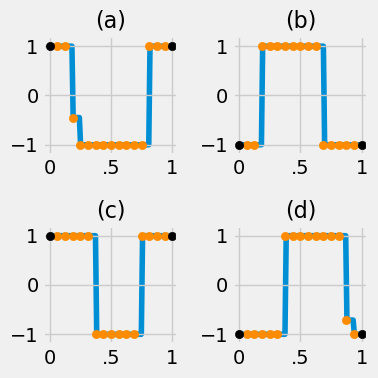

In [209]:
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=results)

### Autoencoder

In [12]:
def objective(latent_var):
    latent_var = np.array(latent_var).reshape(1, -1)
    decoded = decoder.predict(latent_var)
    y_true = objective_function(decoded, m=run, n=sum(nx), J_cb=J_cb, noise=0)
    return y_true

In [9]:
def train_with_feedback(des_pure_train, des_pure_val, feedback_epochs=2, feedback_weight=10):
    sample_weights = np.ones(des_pure_train.shape[0])

    # Initial Training
    latent_dim = 4
    autoencoder, encoder, decoder, history = fit_autoencoder_custom(
        create_autoencoder,
        train_data=des_pure_train,
        val_data=des_pure_val,
        input_dim=des_pure_train.shape[1],
        latent_dim=latent_dim,
        patience=100,
        epochs=1_000,
        batch_size=16,
        alpha=1,
        m=run,
        n=sum(nx),
        J_cb=J_cb,
        noise=0,
        max_layers=100
    )

    for _ in range(feedback_epochs):
        # Obtain a Solution
        res = gp_minimize(
            objective,
            dimensions=[(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(latent_dim)],
            n_calls=10,
            random_state=0,
            verbose=True,
            n_jobs=-1,
            n_random_starts=8,
            acq_func='EI',
            acq_optimizer='sampling'
        )
        optimal_latent_var = res.x
        optimal_des = decoder.predict(np.array(optimal_latent_var).reshape(1, -1)).reshape(1, -1)

        # Add the optimal design to the training set and adjust its weight
        des_pure_train = np.vstack([des_pure_train, optimal_des])
        sample_weights = np.append(sample_weights, feedback_weight)

        # Retrain the autoencoder with sample weights
        history = autoencoder.fit(
            des_pure_train,
            des_pure_train,
            sample_weight=sample_weights,
            epochs=1_000,
            batch_size=16,
            validation_data=(des_pure_val, des_pure_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)]
        )

    return autoencoder, encoder, decoder, history

In [10]:
start = timer()
des_pure_train, des_pure_val,\
des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                             n_x=nx,
                                                             scalars=scalars,
                                                             optimality=optimality,
                                                             J_cb=J_cb,
                                                             noise=0.9,
                                                             num_designs=1_000,
                                                             epsilon=1e-10)


  1%|          | 1000/100000 [00:00<00:04, 23448.50it/s]


In [11]:
# autoencoder, encoder, decoder, history = train_with_feedback(des_pure_train, des_pure_val)
# plot_history(history, title="Custom Loss", threshold=230)

Epoch 1/1000


2023-09-15 17:58:52.185447: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 3s 47ms/step - loss: 3467.4746 - val_loss: 317782.2500
Epoch 2/1000
13/13 [==============================] - 0s 8ms/step - loss: 1253.9048 - val_loss: 133798.0625
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 812.2502 - val_loss: 58288.5586
Epoch 4/1000
13/13 [==============================] - 0s 8ms/step - loss: 572.8335 - val_loss: 27492.9316
Epoch 5/1000
13/13 [==============================] - 0s 8ms/step - loss: 435.8722 - val_loss: 12113.3564
Epoch 6/1000
13/13 [==============================] - 0s 9ms/step - loss: 340.9166 - val_loss: 5600.1514
Epoch 7/1000
13/13 [==============================] - 0s 14ms/step - loss: 273.2596 - val_loss: 2790.6406
Epoch 8/1000
13/13 [==============================] - 0s 15ms/step - loss: 228.3216 - val_loss: 1443.1758
Epoch 9/1000
13/13 [==============================] - 0s 10ms/step - loss: 194.1751 - val_loss: 796.9175
Epoch 10/1000
13/13 [==============================] - 0

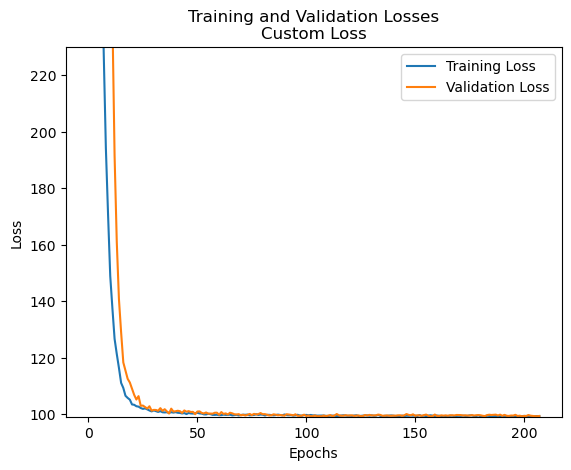

In [12]:
latent_dim = 4
autoencoder, encoder, decoder, history = fit_autoencoder_custom(create_autoencoder_enhanced,
                                                                train_data=des_pure_train, val_data=des_pure_val,
                                                                input_dim=des_pure_train.shape[1], latent_dim=latent_dim, patience=100, epochs=1_000, batch_size=64,
                                                                alpha=1, m=run, n=sum(nx), J_cb=J_cb, noise=0, max_layers=500)
plot_history(history, title="Custom Loss", threshold=230)

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 185ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2338
Function value obtained: 100.3463
Current minimum: 100.3463
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 22ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0481
Function value obtained: 99.5572
Current minimum: 99.5572
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 17ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0424
Function value obtained: 216.6608
Current minimum: 99.5572
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 19ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0442
Function value obtained: 99.5970
Current minimum: 99.5572
Iteratio

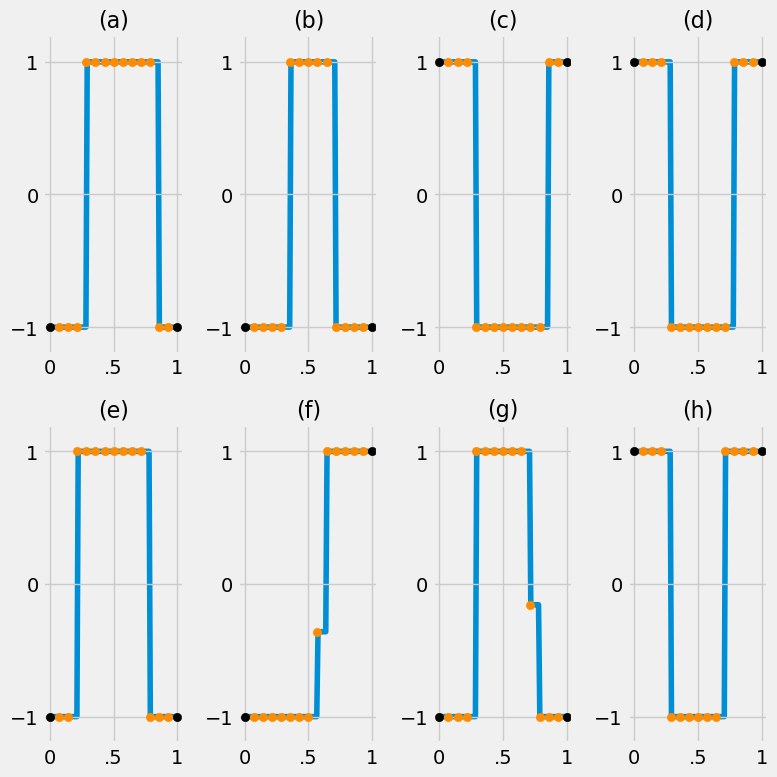

In [13]:
dimensions = [(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(latent_dim)]
res = gp_minimize(objective, dimensions, n_calls=10, random_state=0, verbose=True, n_jobs=-1, n_random_starts=8, acq_func='EI', acq_optimizer='sampling')
end = timer()
optimal_latent_var = res.x
optimal_cr = res.fun

print(f"\n"
      f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(optimal_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")
optimal_des = decoder.predict(np.array(optimal_latent_var).reshape(1, -1)).reshape(run, sum(nx))
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=optimal_des)

In [14]:
# results, all_designs = optimize_designs(encoder, decoder, encoder, decoder, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=10, n_iterations=10, use_denoising=False, use_normal=True)
# best_opt, best_des = find_best_design(results, all_designs)

### Latent space representations

#### Loss function smoothness

In [152]:
plot_3d(decoder, objective_function, runs, n_x, J_cb, filename='interactive_3d_with_minimum.html', xy_points=100)

313/313 [==============================] - 0s 407us/step


In [223]:
plot_3d_v3(decoder, objective_function, runs, n_x, J_cb, chosen_points=res.x_iters, scale='inferno', xy_points=100)

1/1 [==============================] - 0s 18ms/step


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_56487/3593840183.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



#### Robustness

7/7 [==============================] - 0s 2ms/step


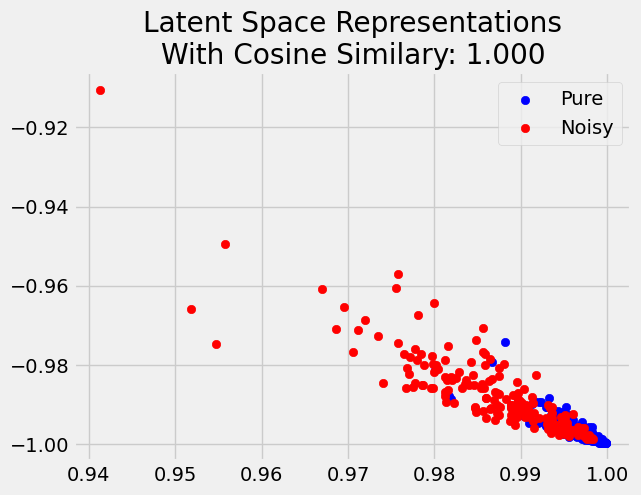

0.999971


In [18]:
pure_embeddings = encoder.predict(des_pure_val)
noisy_embeddings = encoder.predict(des_noisy_val)
# Assuming `pure_embeddings` and `noisy_embeddings` are your embedding vectors
avg_cos_similarity = np.mean(cosine_similarity(pure_embeddings, noisy_embeddings))

plt.scatter(pure_embeddings[:, 0], pure_embeddings[:, 1], c='blue', label='Pure')
plt.scatter(noisy_embeddings[:, 0], noisy_embeddings[:, 1], c='red', label='Noisy')
plt.title(f'Latent Space Representations\nWith Cosine Similary: {avg_cos_similarity:.3f}')
plt.legend()
plt.show()
print(avg_cos_similarity)

#### Examples

##### Stability of Latent Space examples

In [21]:
example_1 = np.array([1, 1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_1).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_1).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

ValueError: in user code:

    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 2)


##### Example 2

1/1 [==============================] - 0s 11ms/step


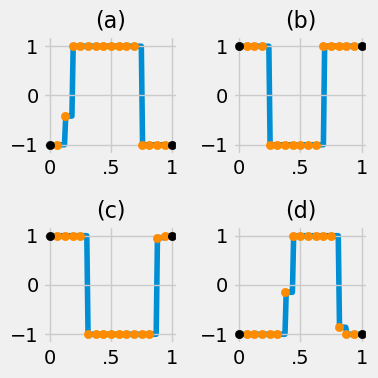

1/1 [==============================] - 0s 13ms/step
Bad example criterion: 209.86420142044315


In [230]:
example_2 = np.array([1, -1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_2).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_2).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

##### Example 3

1/1 [==============================] - 0s 12ms/step


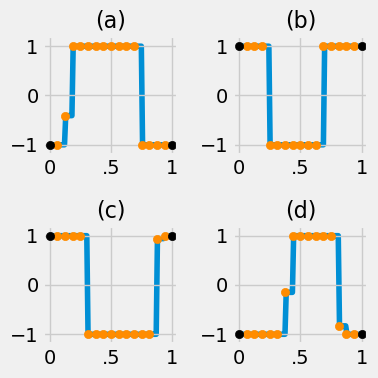

1/1 [==============================] - 0s 14ms/step
Bad example criterion: 209.85304978989578


In [231]:
example_3 = np.array([-1, 1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_3).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_3).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

##### Example 4

1/1 [==============================] - 0s 20ms/step


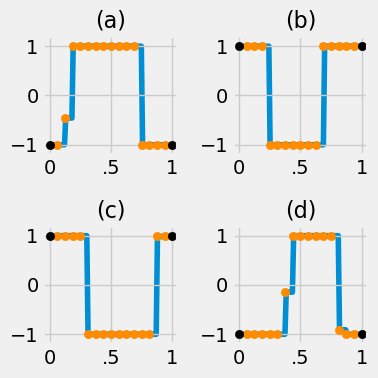

1/1 [==============================] - 0s 11ms/step
Bad example criterion: 209.93716298470775


In [232]:
example_4 = np.array([-1, -1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_4).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_4).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

#### Contour & Trajectory plot

31250/31250 [==============================] - 10s 313us/step


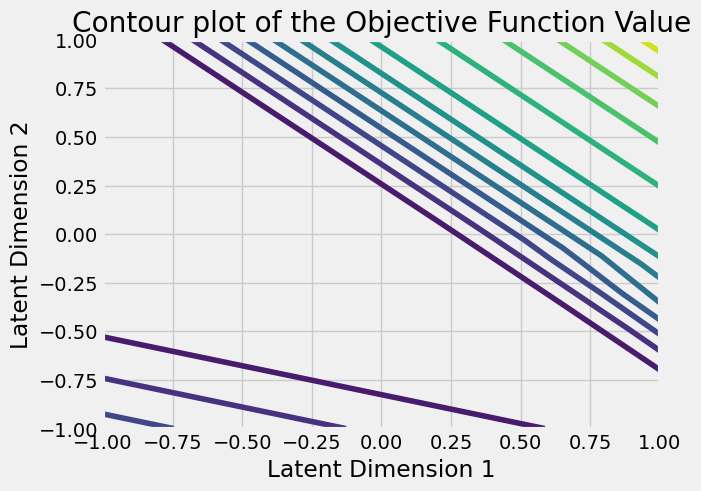

In [233]:
plot_contour(decoder, objective_function, runs, n_x, J_cb, levels=15, xy_points=100)

### Table of results

In [9]:
runs = [4,8,12]
optimality = 'A'
n_x = [[3],[4],[8],[16],[100]]
n_b = [3]
latent_dims = [2, 2, 2, 7, 40,    # 4
               2, 5, 2, 4, 15,    # 8
               3, 1, 3, 10, 10]   # 12
scalars = 0
import pandas as pd
import math

In [9]:
results_df = pd.DataFrame(columns=['run', 'nx', 'time', 'latent_dim', 'patience', 'best_optimality'])
counter = 0
for run in tqdm(runs):
    for nx in n_x:
        # print(f'Run: {run}, nx: {nx}')
        # latent_dim = int(math.ceil(run*nx[0]/10))
        # if nx[0]<100:
        #     patience = 5*run*nx[0]
        # else:
        #     patience = nx[0]

        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
        start = timer()
        des_pure_train, des_pure_val,\
        des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                 n_x=nx,
                                                                 scalars=scalars,
                                                                 optimality=optimality,
                                                                 J_cb=J_cb,
                                                                 noise=0.9,
                                                                 num_designs=1_000,
                                                                 epsilon=1e-10)

        autoencoder, encoder, decoder, history = fit_autoencoder_custom(create_autoencoder,
                                                                        train_data=des_pure_train, val_data=des_pure_val,
                                                                        input_dim=des_pure_train.shape[1], latent_dim=latent_dims[counter], patience=100, epochs=1_000, batch_size=128,
                                                                        alpha=1, m=run, n=sum(nx), J_cb=J_cb, noise=0, max_layers=10)
        dimensions = [(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(latent_dims[counter])]
        res = gp_minimize(objective, dimensions, n_calls=8, random_state=0, verbose=False, n_jobs=-1, n_random_starts=8, acq_func='EI', acq_optimizer='sampling')
        end = timer()
        elapsed_time = str(timedelta(seconds=end-start))  # convert seconds to hh:mm:ss format

        # Get the best optimality score (modify this line based on how you can retrieve the score)
        best_optimality = res.fun

        # Append to the DataFrame
        results_df = results_df.append({
            'run': run,
            'nx': nx,
            'time': elapsed_time,
            'latent_dim': latent_dims[counter],
            'patience': 100,
            'best_optimality': np.round(best_optimality,3)
        }, ignore_index=True)
        counter += 1

# Save to a CSV file
results_df.to_csv('results.csv', index=False)

  1%|          | 1008/100000 [00:00<00:01, 65903.77it/s]

Epoch 1/1000



2023-07-28 16:02:27.889932: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 1s 21ms/step - loss: 812783.0625 - val_loss: 382255.1562
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 320546.7188 - val_loss: 225922.0000
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 203032.5625 - val_loss: 159516.0625
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 149895.5156 - val_loss: 119742.9375
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 116039.7266 - val_loss: 92523.9219
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 91523.1016 - val_loss: 73347.9766
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 73690.5078 - val_loss: 58985.5781
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 59197.4219 - val_loss: 47623.4492
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 47578.0703 - val_loss: 39286.8633
Epoch 10/1000
7/7 [==============================

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1006/100000 [00:00<00:01, 78190.46it/s]

Epoch 1/1000


7/7 [==============================] - 1s 25ms/step - loss: 517716.4062 - val_loss: 173013.5156
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 152886.6094 - val_loss: 100172.2109
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 97986.5781 - val_loss: 68145.5391
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 68930.6484 - val_loss: 49766.9961
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 51428.6289 - val_loss: 37658.9609
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 38228.2656 - val_loss: 28968.8496
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 29965.4375 - val_loss: 22832.8105
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 24203.3047 - val_loss: 17914.3926
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 19469.4316 - val_loss: 14255.4336
Epoch 10/1000
7/7 [==============================] - 0

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1025/100000 [00:00<00:01, 67155.51it/s]


Epoch 1/1000
7/7 [==============================] - 1s 33ms/step - loss: 394043.1875 - val_loss: 165581.5625
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 147626.4531 - val_loss: 92737.7188
Epoch 3/1000
7/7 [==============================] - 0s 5ms/step - loss: 84510.0781 - val_loss: 62936.5312
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 67282.9062 - val_loss: 44903.2383
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 42926.0547 - val_loss: 33534.8203
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 34658.1211 - val_loss: 25222.5234
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 24706.5098 - val_loss: 19489.4062
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 18704.3066 - val_loss: 15175.0996
Epoch 9/1000
7/7 [==============================] - 0s 9ms/step - loss: 16105.6260 - val_loss: 11849.7178
Epoch 10/1000
7/7 [=======================

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1064/100000 [00:00<00:01, 81626.02it/s]

Epoch 1/1000


7/7 [==============================] - 1s 22ms/step - loss: 384523.3750 - val_loss: 101277.1875
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 77369.7109 - val_loss: 54382.8281
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 45471.4844 - val_loss: 33394.3789
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 28084.1523 - val_loss: 22587.7402
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 18807.5156 - val_loss: 15283.2441
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 12716.5283 - val_loss: 10364.6084
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 8742.1660 - val_loss: 6971.7896
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 5982.4775 - val_loss: 4780.9263
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 4119.7324 - val_loss: 3380.9399
Epoch 10/1000
7/7 [==============================] - 0s 3ms/st

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  2%|▏         | 2272/100000 [00:00<00:01, 81956.21it/s]


Epoch 1/1000
7/7 [==============================] - 1s 25ms/step - loss: 253428.6406 - val_loss: 14514.1445
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 11137.5947 - val_loss: 7794.9927
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 6301.5176 - val_loss: 4686.1328
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 3888.8730 - val_loss: 3029.4250
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 2558.1753 - val_loss: 2058.9043
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 1779.3936 - val_loss: 1456.8147
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 1280.3531 - val_loss: 1072.9164
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 959.9697 - val_loss: 810.3802
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 731.4193 - val_loss: 628.5963
Epoch 10/1000
7/7 [==============================] - 0s 5ms/ste

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
  1%|          | 1000/100000 [00:00<00:01, 67855.82it/s]

Epoch 1/1000


7/7 [==============================] - 1s 16ms/step - loss: 515886.1562 - val_loss: 198259.0469
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 161158.5625 - val_loss: 114071.6797
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 99132.8203 - val_loss: 78806.6484
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 70108.4531 - val_loss: 58079.8086
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 52333.2305 - val_loss: 44312.4805
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 40717.5703 - val_loss: 34287.1523
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 31467.1133 - val_loss: 26979.8145
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 24606.6973 - val_loss: 21316.1133
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 19658.0449 - val_loss: 16950.8398
Epoch 10/1000
7/7 [==============================] - 0

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 64926.30it/s]

Epoch 1/1000


7/7 [==============================] - 1s 20ms/step - loss: 34264.1406 - val_loss: 18665.2422
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 13928.9600 - val_loss: 12027.0254
Epoch 3/1000
7/7 [==============================] - 0s 8ms/step - loss: 9116.0547 - val_loss: 8650.2021
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - loss: 6524.7207 - val_loss: 6536.0610
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 5050.2764 - val_loss: 5022.2817
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 4052.3149 - val_loss: 3860.0532
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 3076.8328 - val_loss: 3023.9307
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 2436.1755 - val_loss: 2397.9658
Epoch 9/1000
7/7 [==============================] - 0s 4ms/step - loss: 2029.7500 - val_loss: 1922.1656
Epoch 10/1000
7/7 [==============================] - 0s 4ms/step - loss:

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 86029.95it/s]

Epoch 1/1000


7/7 [==============================] - 1s 19ms/step - loss: 628517.2500 - val_loss: 200975.4062
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 167561.9219 - val_loss: 101769.0000
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 90525.6094 - val_loss: 61895.7188
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 57308.2305 - val_loss: 40774.4883
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 38000.3203 - val_loss: 27740.2148
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 26181.2891 - val_loss: 19694.4121
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 18988.3359 - val_loss: 14308.2695
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 13516.8359 - val_loss: 10583.0039
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 9997.6367 - val_loss: 7907.6724
Epoch 10/1000
7/7 [==============================] - 0s 

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 73378.31it/s]

Epoch 1/1000


7/7 [==============================] - 1s 19ms/step - loss: 840893.3750 - val_loss: 157849.5938
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 104719.6328 - val_loss: 56736.2344
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 44938.3438 - val_loss: 29164.6719
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 24906.8984 - val_loss: 17091.9258
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 15550.0186 - val_loss: 10723.5029
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 9509.4336 - val_loss: 7161.3931
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 6318.8467 - val_loss: 5059.8296
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 4693.3521 - val_loss: 3622.3955
Epoch 9/1000
7/7 [==============================] - 0s 4ms/step - loss: 3430.8757 - val_loss: 2630.1638
Epoch 10/1000
7/7 [==============================] - 0s 4ms/ste

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 65189.68it/s]

Epoch 1/1000


7/7 [==============================] - 1s 26ms/step - loss: 346873.3750 - val_loss: 6567.5625
Epoch 2/1000
7/7 [==============================] - 0s 12ms/step - loss: 5588.2349 - val_loss: 3499.9438
Epoch 3/1000
7/7 [==============================] - 0s 12ms/step - loss: 2821.8003 - val_loss: 1816.4939
Epoch 4/1000
7/7 [==============================] - 0s 12ms/step - loss: 1540.7700 - val_loss: 1081.3762
Epoch 5/1000
7/7 [==============================] - 0s 11ms/step - loss: 951.3290 - val_loss: 711.8251
Epoch 6/1000
7/7 [==============================] - 0s 11ms/step - loss: 628.8957 - val_loss: 487.7965
Epoch 7/1000
7/7 [==============================] - 0s 10ms/step - loss: 437.8107 - val_loss: 343.2750
Epoch 8/1000
7/7 [==============================] - 0s 13ms/step - loss: 314.3280 - val_loss: 253.5053
Epoch 9/1000
7/7 [==============================] - 0s 13ms/step - loss: 233.1013 - val_loss: 199.2842
Epoch 10/1000
7/7 [==============================] - 0s 12ms/step - loss: 18

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
  1%|          | 1000/100000 [00:00<00:01, 65962.70it/s]

Epoch 1/1000


7/7 [==============================] - 1s 16ms/step - loss: 11564.3174 - val_loss: 3833.7625
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 4971.7856 - val_loss: 2616.8015
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 3301.4333 - val_loss: 1938.0106
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 2295.0669 - val_loss: 1502.3481
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 1633.6689 - val_loss: 1200.8132
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 1494.3597 - val_loss: 934.1898
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 1032.9362 - val_loss: 770.7939
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 899.3940 - val_loss: 622.4073
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 664.7294 - val_loss: 525.3990
Epoch 10/1000
7/7 [==============================] - 0s 3ms/step - loss: 589.3947

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 78260.70it/s]

Epoch 1/1000


7/7 [==============================] - 1s 19ms/step - loss: 558230.0625 - val_loss: 141424.2969
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 111007.0703 - val_loss: 72557.5078
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 63657.3086 - val_loss: 45602.3711
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 41067.5898 - val_loss: 31350.6523
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 28518.3828 - val_loss: 22445.9258
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 20646.9707 - val_loss: 16341.8838
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 15320.4541 - val_loss: 12078.0508
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 11322.4541 - val_loss: 8975.8867
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 8382.4229 - val_loss: 6742.7129
Epoch 10/1000
7/7 [==============================] - 0s 3m

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 74918.35it/s]

Epoch 1/1000


7/7 [==============================] - 1s 18ms/step - loss: 612006.8125 - val_loss: 140988.7031
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 98321.1562 - val_loss: 57563.1016
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 45481.6250 - val_loss: 31160.5801
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 25758.7676 - val_loss: 18990.0020
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 16339.3379 - val_loss: 12298.6523
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 10903.2529 - val_loss: 8295.3291
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 7254.2280 - val_loss: 5783.8130
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 5206.4390 - val_loss: 4065.7268
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 3691.2654 - val_loss: 2914.4233
Epoch 10/1000
7/7 [==============================] - 0s 3ms/ste

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 67593.37it/s]

Epoch 1/1000


7/7 [==============================] - 1s 22ms/step - loss: 141409.9062 - val_loss: 18240.0000
Epoch 2/1000
7/7 [==============================] - 0s 5ms/step - loss: 12977.6387 - val_loss: 8075.8506
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 6208.6592 - val_loss: 4415.1387
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 3620.8962 - val_loss: 2645.2319
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 2181.2996 - val_loss: 1662.6547
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 1415.3491 - val_loss: 1117.7961
Epoch 7/1000
7/7 [==============================] - 0s 4ms/step - loss: 975.4199 - val_loss: 785.4587
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 710.2889 - val_loss: 566.2917
Epoch 9/1000
7/7 [==============================] - 0s 4ms/step - loss: 513.0883 - val_loss: 409.5281
Epoch 10/1000
7/7 [==============================] - 0s 4ms/step - loss: 370.7

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

  1%|          | 1000/100000 [00:00<00:01, 60390.54it/s]

Epoch 1/1000


7/7 [==============================] - 1s 33ms/step - loss: 304396.0000 - val_loss: 1907.5947
Epoch 2/1000
7/7 [==============================] - 0s 19ms/step - loss: 1347.9510 - val_loss: 734.3773
Epoch 3/1000
7/7 [==============================] - 0s 19ms/step - loss: 597.2060 - val_loss: 400.4894
Epoch 4/1000
7/7 [==============================] - 0s 18ms/step - loss: 347.9013 - val_loss: 262.1609
Epoch 5/1000
7/7 [==============================] - 0s 19ms/step - loss: 234.8799 - val_loss: 188.0487
Epoch 6/1000
7/7 [==============================] - 0s 18ms/step - loss: 171.8246 - val_loss: 137.7340
Epoch 7/1000
7/7 [==============================] - 0s 19ms/step - loss: 127.9800 - val_loss: 107.4132
Epoch 8/1000
7/7 [==============================] - 0s 17ms/step - loss: 101.6679 - val_loss: 90.0280
Epoch 9/1000
7/7 [==============================] - 0s 18ms/step - loss: 86.5230 - val_loss: 79.8646
Epoch 10/1000
7/7 [==============================] - 0s 19ms/step - loss: 77.8928 - 

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_42701/2595222312.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
100%|██████████| 3/3 [02:54<00:00, 58.12s/it]


In [10]:
literature_optimality = [386.408,246.869,218.479,208.843,206.884,189.766,103.553,99.109,97.408,96.709,126.409,67.735,65.217,63.610,63.028]
results_df['literature_optimality'] = pd.Series(literature_optimality)
results_df['diff'] = round(results_df['best_optimality'] - results_df['literature_optimality'], 3)
results_df['eff'] = round(results_df['literature_optimality'] / results_df['best_optimality']*100, 2)

In [11]:
results_df.to_csv('./results/results.csv', index=False)

In [10]:
# Initialize a second DataFrame to store results from the second loop
results_df2 = pd.DataFrame(columns=['run', 'nx', 'time', 'best_cr'])

runs = [4,8,12]
optimality = 'A'
n_x = [[3],[4],[8],[16],[100]]
n_b = [3]
scalars = 0

for run in runs:
    for nx in n_x:
        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])

        start = timer()
        results, best_cr = cordex_continuous(runs=run,
                                             f_list=nx,
                                             scalars=scalars,
                                             epochs=1000,
                                             J_cb=J_cb,
                                             optimality=optimality)
        end = timer()

        elapsed_time = str(timedelta(seconds=end-start))  # convert seconds to hh:mm:ss format

        # Append to the DataFrame
        results_df2 = results_df2.append({
            'run': run,
            'nx': nx,
            'time': elapsed_time,
            'best_cr': best_cr
        }, ignore_index=True)

# Save to a CSV file
results_df2.to_csv('results2.csv', index=False)

100%|██████████| 1000/1000 [00:35<00:00, 28.37it/s]
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_51102/276181053.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df2 = results_df2.append({
100%|██████████| 1000/1000 [00:39<00:00, 25.24it/s]
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_51102/276181053.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df2 = results_df2.append({
100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_51102/276181053.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df2 = results_df2.append({
100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s]
/var/folders/bb/tzggm8cx2f5fyxfhdmmh

In [18]:
# Merge the two dataframes on 'run' and 'nx' columns
results_df = pd.read_csv('./results/results.csv')
results_df2 = pd.read_csv('results2.csv')
merged_df = pd.merge(results_df, results_df2, how='inner', on=['run', 'nx'])

# Save the merged dataframe to a CSV file
merged_df.to_csv('./results/merged_results.csv', index=False)

In [19]:
# Function to convert hh:mm:ss into seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

# Apply the function to the 'time' columns
merged_df['time_x'] = merged_df['time_x'].apply(get_sec)
merged_df['time_y'] = merged_df['time_y'].apply(get_sec)

# Drop the 'best_cr' column
merged_df = merged_df.drop(columns=['best_cr'])

# Create a 'time_reduction' column
merged_df['time_reduction'] = np.log2(merged_df['time_y']) - np.log2(merged_df['time_x'])

# Save the modified dataframe to a CSV file
merged_df.to_csv('./results/modified_merged_results.csv', index=False)


In [21]:
times = [1.8616282029555689,
         1.6973874299596465,
         3.1739781799092808,
         3.563319765948993,
         5.222386847745202,
         ]

In [22]:
print(np.round(times,3))

[1.862 1.697 3.174 3.563 5.222]


## Hybrid

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [9]:
from gen_rand_design import gen_rand_design_m  # custom function for generating random designs
from scipy.optimize import minimize

def cordex_continuous_hybrid(runs, f_list, scalars, optimality='A', J_cb=None, R_0=None, smooth_pen=0, ridge_pen=0,
                      epochs=1000, estimator='MLE', smoothness_lambda=0,
                      method='L-BFGS-B', random_start=False, final_pass=True, final_pass_iter=100,
                      main_bar=True, starting_bar=False, final_bar=True, neural_network_start=False, optimal_des=None, optimal_cr=None):
    def objective(x):
        """
        Objective function for D-optimality or A-optimality criterion.

        Args:
            x (numpy.ndarray): The coordinate that is to be changed in the design matrix.

        Returns:
            float: The D-optimality or A-optimality value of the design.

        Raises:
            ValueError: If the specified optimality criterion is not one of 'D' or 'A'.
        """

        Model_mat[run, feat] = x
        Gamma = Model_mat[:, :f_coeffs]
        X = Model_mat[:, f_coeffs:]
        Zetta = np.concatenate((ones, Gamma @ J_cb, X), axis=1)
        Mu = Zetta.T @ Zetta

        # Good idea but it needs a PEA instead of a CEA to work properly
        # smoothness_penalty = 0
        # for r in range(Model_mat.shape[0]):
        #     for i in range(1, Model_mat.shape[1]):
        #         smoothness_penalty += np.abs(Model_mat[r, i] - Model_mat[r, i - 1])

        if R_0 is None and ridge_pen == 0:
            P = Mu
        else:
            if R_0 is None:
                P = Mu + ridge_pen * np.identity(Mu.shape[0])
            elif ridge_pen == 0:
                P = Mu + smooth_pen * R_0
            else:
                P = Mu + smooth_pen * R_0 + ridge_pen * np.identity(Mu.shape[0])
        try:
            P_inv = np.linalg.inv(P)
        except np.linalg.LinAlgError:
            return np.nan

        if estimator == 'MLE':
            MATRIX = P_inv @ Mu @ P_inv
        elif estimator == 'Bayes':
            MATRIX = P_inv
        else:
            raise ValueError(f"Invalid estimator {estimator}. "
                             "Estimator should be one of 'MLE', or 'Bayes'.")
        if np.isclose(np.linalg.det(MATRIX), 0):
            return np.nan

        if optimality == 'D':
            value = np.linalg.det(MATRIX)
            if np.isclose(value, 0, atol=1e-8):
                value = np.nan
            return value
        elif optimality == 'A':
            value = np.trace(MATRIX)
            if np.isclose(value, 0, atol=1e-8):
                value = np.nan
            return value
        else:
            raise ValueError(f"Invalid criterion {optimality}. "
                             "Criterion should be one of 'D', or 'A'.")

    def check(obj):
        if optimality in ['A']:
            return 0 <= obj < Best_obj
            # return obj < Best_obj
        elif optimality in ['D']:
            return 0 <= obj < Best_obj
            # return obj < Best_obj

    def run_checks():
        if method not in ['Nelder-Mead', 'Powell', 'TNC', 'L-BFGS-B']:
            raise ValueError(f"Invalid method {method}. "
                             "Method should be one of 'Nelder-Mead', 'Powell', 'TNC', or 'L-BFGS-B'.")
        if runs < J_cb.shape[1] + scalars + 1 and smooth_pen == 0 and ridge_pen == 0:
            raise ValueError(f"Design not Estimable."
                             f"Runs {runs}, Parameters: {sum(f_list) + scalars}, with no penalty.")
        if R_0 is None and smooth_pen != 0:
            raise ValueError(f"Smoothness penalty is set to {smooth_pen}, but no smoothness matrix is provided.")
        if R_0 is not None and smooth_pen == 0:
            raise ValueError(f"Smoothness matrix is provided, but smoothness penalty is set to {smooth_pen}.")

    run_checks()
    Best_des = None
    Best_obj = np.inf
    f_coeffs = sum(f_list) + 1
    ones = np.ones((runs, 1))

    if neural_network_start and optimal_des is not None:
        Model_mat = optimal_des  # Use the provided optimal design as the starting design
        Best_obj = optimal_cr
    else:
        if random_start:
            Gamma_, X_ = gen_rand_design_m(runs=runs, f_list=f_list, scalars=scalars)
            Model_mat = np.hstack((Gamma_, X_))
        else:
            Model_mat, _ = cordex_discrete(runs=runs, f_list=f_list, scalars=scalars, levels=[-1, 1], epochs=10,
                                           optimality=optimality, J_cb=J_cb, disable_bar=not starting_bar)

    if not neural_network_start:  # If not using neural network start, proceed with the main loop
        for _ in tqdm(range(epochs), disable=not main_bar):
            objective_value = np.inf
            if random_start:
                Gamma_, X_ = gen_rand_design_m(runs=runs, f_list=f_list, scalars=scalars)
                Model_mat = np.hstack((Gamma_, X_))
            else:
                Model_mat, _ = cordex_discrete(runs=runs, f_list=f_list, scalars=scalars, levels=[-1, 1], epochs=10,
                                               optimality=optimality, J_cb=J_cb, disable_bar=not starting_bar)
            for run in range(runs):
                for feat in range(f_coeffs + scalars - 1):
                    res = minimize(objective, Model_mat[run, feat], method=method, bounds=[(-1, 1)])
                    if res.x is not None:
                        Model_mat[run, feat] = res.x
                    objective_value = objective(res.x)

            if check(objective_value):
                Best_obj = objective_value
                Best_des = Model_mat

    if final_pass:
        if final_bar:
            print("Executing final pass...")
        for _ in tqdm(range(final_pass_iter), disable=not final_bar):
            objective_value = Best_obj
            for run in range(Model_mat.shape[0]):
                for feat in range(Model_mat.shape[1]):
                    res = minimize(objective, Model_mat[run, feat], method=method, bounds=[(-1, 1)])
                    Model_mat[run, feat] = res.x
                    objective_value = objective(res.x)
                    if np.isclose(objective_value, 0, atol=1e-15):
                        objective_value = 0
            if check(objective_value):
                Best_obj = objective_value
                Best_des = Model_mat

    return Best_des, np.abs(Best_obj)

def objective(latent_var):
    latent_var = np.array(latent_var).reshape(1, -1)
    decoded = decoder.predict(latent_var)
    y_true = objective_function(decoded, m=run, n=sum(nx), J_cb=J_cb, noise=0)
    return y_true

In [10]:
runs = [4,8,12]
n_x = [[3],[4],[8],[16],[100]]
n_b = [3]
latent_dims = [2, 2, 2, 7, 40,    # 4
               2, 5, 2, 4, 15,    # 8
               3, 1, 3, 10, 10]   # 12

In [11]:
counter = 0
for run in tqdm(runs):
    for nx in n_x:
        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
        des_pure_train, des_pure_val,\
        des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                     n_x=nx,
                                                                     scalars=scalars,
                                                                     optimality=optimality,
                                                                     J_cb=J_cb,
                                                                     noise=0.9,
                                                                     num_designs=1_000,
                                                                     epsilon=1e-10)

        autoencoder, encoder, decoder, history = fit_autoencoder_custom(create_autoencoder,
                                                                        train_data=des_pure_train, val_data=des_pure_val,
                                                                        input_dim=des_pure_train.shape[1], latent_dim=latent_dims[counter], patience=300, epochs=1_000, batch_size=128,
                                                                        alpha=1, m=run, n=sum(nx), J_cb=J_cb, noise=0, max_layers=10)
        dimensions = [(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(latent_dims[counter])]
        res = gp_minimize(objective, dimensions, n_calls=10, random_state=0, verbose=False, n_jobs=-1, n_random_starts=8, acq_func='EI', acq_optimizer='sampling')
        end = timer()
        elapsed_time = str(timedelta(seconds=end-start))  # convert seconds to hh:mm:ss format

        # Get the best optimality score (modify this line based on how you can retrieve the score)
        best_optimality = res.fun

        # Append to the DataFrame
        counter += 1

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'scalars' is not defined

In [74]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

decay_epoch = 100
num_designs = 1_000
batch_size = 256

decay_steps = decay_epoch * (num_designs / batch_size)

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=decay_steps,
    decay_rate=0.9,
    staircase=False)



run = 4
sub_x = 2
sub_y = 2
epochs = 1_000
patience_prc = 0.2
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [100]
n_b = [3]
latent_dim = 7
scalars = 0
optimizer_parameters = {'learning_rate': 0.01}
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])

des_pure_train, des_pure_val,\
des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                             n_x=nx,
                                                             scalars=scalars,
                                                             optimality=optimality,
                                                             J_cb=J_cb,
                                                             noise=0.9,
                                                             num_designs=num_designs,
                                                             epsilon=1e-10)

  2%|▏         | 2275/100000 [00:00<00:01, 71383.46it/s]


In [75]:
def latent_dim_objective(params):
    latent_dim = int(params[0])  # Extract and convert to integer
    exponent = params[1]  # Extract exponent

    if exponent == 0:
        alpha = 0
    else:
        alpha = 10.0**exponent # Convert to order of magnitude

    # Create and train the autoencoder with the given latent_dim and alpha
    autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                       latent_dim=latent_dim,
                                                       max_layers=500,
                                                       alpha=alpha)

    _, _, _, history = fit_autoencoder_custom(autoencoder, encoder, decoder,
                                              optimizer=RMSprop,
                                              optimizer_kwargs=optimizer_parameters,
                                              train_data=des_pure_train, val_data=des_pure_val,
                                              patience=10, epochs=100, batch_size=batch_size,
                                              alpha=1, m=run, n=sum(nx), J_cb=J_cb, noise=0)

    # Return the final validation loss as the objective to minimize
    val_loss = history.history['val_loss'][-1]
    return val_loss

In [82]:
# Define the search space for latent_dim and alpha
search_space = [(1, sum(nx)),  # Range for latent_dim
                (-6, 0)]  # Range for exponent of alpha

res = gp_minimize(latent_dim_objective, search_space, n_calls=10, random_state=0, verbose=True, n_jobs=-1, n_random_starts=5, acq_func='EI', acq_optimizer='sampling')

# Extract the best latent_dim and alpha
best_latent_dim = int(res.x[0])
best_exponent = res.x[1]

if best_exponent == 0:
    best_alpha = 0
else:
    best_alpha = 10.0**best_exponent

print(f"Optimal Latent Dimension: {best_latent_dim}")
print(f"Optimal Alpha: {best_alpha}")

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100
4/4 [==============================] - 1s 45ms/step - loss: 307093.6875 - val_loss: 612.4742
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 588.2110 - val_loss: 523.3588
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 500.5923 - val_loss: 464.5161
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 457.2692 - val_loss: 438.1589
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 429.8342 - val_loss: 411.4897
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 407.9732 - val_loss: 400.1670
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 398.1566 - val_loss: 390.4707
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 387.1237 - val_loss: 382.0356
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 380.4924 - val_loss: 374.9711
Epoch 10/100
4/4 [=====

/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


4/4 [==============================] - 2s 85ms/step - loss: 469688.7500 - val_loss: 718.6766
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 662.3990 - val_loss: 553.0415
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 530.1780 - val_loss: 476.6342
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 458.9481 - val_loss: 411.8320
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 399.3892 - val_loss: 376.0116
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 370.4352 - val_loss: 359.6849
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 356.2044 - val_loss: 344.1814
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 340.7908 - val_loss: 331.2144
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 326.3124 - val_loss: 311.9194
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 307.6935 - val_loss: 297.

In [77]:
autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                   latent_dim=best_latent_dim,
                                                   max_layers=500,
                                                   alpha=best_alpha)

autoencoder, encoder, decoder, history = fit_autoencoder_custom(autoencoder, encoder, decoder,
                                                                optimizer=RMSprop,
                                                                optimizer_kwargs=optimizer_parameters,
                                                                train_data=des_pure_train, val_data=des_pure_val,
                                                                 patience=int(patience_prc*epochs), epochs=epochs, batch_size=batch_size,
                                                                alpha=1, m=run, n=sum(nx), J_cb=J_cb, noise=0)

dimensions = [(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(best_latent_dim)]
res = gp_minimize(objective, dimensions, n_calls=80, random_state=0, verbose=True, n_jobs=-1, n_random_starts=8, acq_func='PI', acq_optimizer='sampling')
optimal_latent_var = res.x
optimal_cr = res.fun
optimal_des = decoder.predict(np.array(optimal_latent_var).reshape(1, -1)).reshape(run, sum(nx))
print(np.round(optimal_cr,3))

results2 = np.round(optimal_des,3)
Z = np.concatenate((np.ones((4,1)), results2[:, :sum(nx)] @ J_cb, results2[:, sum(nx):]), axis=1)
print(np.round(np.trace(np.linalg.inv(Z.T @ Z)),3))

Epoch 1/1000
4/4 [==============================] - 1s 38ms/step - loss: 1163211.2500 - val_loss: 769.8887
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 689.7818 - val_loss: 531.1581
Epoch 3/1000
4/4 [==============================] - 0s 8ms/step - loss: 494.7747 - val_loss: 413.3030
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 391.7081 - val_loss: 342.6046
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 329.9804 - val_loss: 301.5046
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 293.9296 - val_loss: 275.8182
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 270.6820 - val_loss: 257.8723
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 254.1530 - val_loss: 244.3211
Epoch 9/1000
4/4 [==============================] - 0s 8ms/step - loss: 240.9542 - val_loss: 228.6283
Epoch 10/1000
4/4 [==============================] - 0s 8ms/step - loss: 225

In [48]:
results, best_cr = cordex_continuous_hybrid(runs=run, f_list=nx, scalars=0, optimality=optimality, J_cb=J_cb, final_pass=True, neural_network_start=True, optimal_des=optimal_des, optimal_cr=optimal_cr,final_pass_iter=1, method='Nelder-Mead')
best_cr

Executing final pass...


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


218.47928200989867

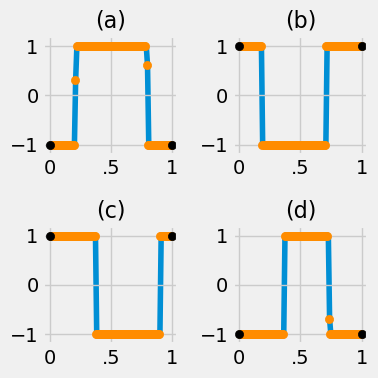

In [79]:
result_diagram = subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=np.round(optimal_des,3), show=False)

In [11]:
start = timer()
results_2, best_cr_2 = cordex_continuous(runs=run,
                                       f_list=nx,
                                       scalars=scalars,
                                       epochs=1000,
                                       J_cb=J_cb,
                                       optimality=optimality,)
end = timer()
print(best_cr_2)

100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


97.42683200940479
